In [1]:
import os
import tarfile
import geoip2.database
from scapy.all import *
import concurrent.futures

In [2]:
isp_asns = {}

with open('isp_to_asns_map.txt', 'r', encoding='latin-1') as file:
    # Read each line in the file
    for line in file:
        # Split the line at the comma
        parts = line.strip().split(',')
        # Extract ISP name (first part)
        isp_name = parts[0].strip()
        # Extract list of ASN numbers (remaining parts)
        asns = [asn.strip() for asn in parts[1:]]
        # Update dictionary with ASN numbers as keys and ISP name as value
        for asn in asns:
            isp_asns[float(asn)] = isp_name

print(len(isp_asns))

2612


In [36]:
import os
import tarfile

def extract_and_analyze(folder_path, num_files=1):
    tgz_files = [f for f in os.listdir(folder_path) if f.endswith('.tgz')]
    tgz_files = tgz_files[:min(num_files, len(tgz_files))]
    pcap_files = []

    for tgz_file in tgz_files:
        with tarfile.open(os.path.join(folder_path, tgz_file), 'r:gz') as tar:
            extracted_folder_name = os.path.splitext(tgz_file)[0]
            pcap_folder = os.path.join(folder_path, extracted_folder_name)
            tar.extractall(pcap_folder)
            pcap_folder = os.path.join(pcap_folder, '2024', '03','01')
            pcap_files.extend([os.path.join(pcap_folder, f) for f in os.listdir(pcap_folder) ])
    
    return pcap_files

pcap_files = extract_and_analyze('/data/mlab', num_files=500)

In [2]:
import os
import shutil
import csv
from scapy.all import *
import geoip2.database

def map_ip_address(pcap_files, csv_file_name):
    # Load the MaxMind ASN database
    reader = geoip2.database.Reader(r"GeoLite2-ASN.mmdb")

    # List to store data for CSV
    csv_data = []


    for pcap_file in pcap_files:
        with PcapReader(pcap_file) as pcap_reader:
            packet = pcap_reader.read_packet()
            ip_addresses = set()
            if IP in packet:
                ip_addresses.add(packet[IP].src)
                ip_addresses.add(packet[IP].dst)

            for ip_address in ip_addresses:
                try:
                    response = reader.asn(ip_address)
                    as_number = response.autonomous_system_number
                    isp_name = isp_asns.get(as_number)
                    if isp_name is not None:
                        csv_data.append([pcap_file, isp_name, as_number])
                except geoip2.errors.AddressNotFoundError:
                    pass
                except Exception as e:
                    print(f"Error processing IP {ip_address}: {e}")

    

    reader.close()

    with open(csv_file_name, mode='w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['PCAP File', 'ISP Name', 'AS Number'])
        csv_writer.writerows(csv_data)

map_ip_address(pcap_files,"data.csv")

NameError: name 'pcap_files' is not defined

In [12]:
import pandas as pd

def top_30_isp(csv_file_name):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_name)

    # Get the top 30 ISPs
    top_isps = df['ISP Name'].value_counts().head(30)

    return top_isps

def filter_top_isps(csv_file_name, top_isps):
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_file_name)

    # Filter the DataFrame to include only the rows corresponding to the top 30 ISPs
    filtered_df = df[df['ISP Name'].isin(top_isps.index)]

    # Write the filtered DataFrame to a new CSV file
    filtered_df.to_csv('top_30_isps.csv', index=False)

    # Print the top 30 ISPs with their frequencies
    print("Top 30 ISPs with their frequencies:")
    for isp, frequency in top_isps.items():
        print(f"{isp}: {frequency}")

# Assuming your CSV file is named "data.csv"
top_isps = top_30_isp("data.csv")
filter_top_isps("data.csv", top_isps)


Top 30 ISPs with their frequencies:
Cogent/PSI: 5659
Cable and Wireless Worldwide: 4775
BHARTI Airtel: 3728
Level 3 Communications: 3600
TATA Communications formerly VSNL is Leading ISP: 3551
Reliance Jio INFOCOMM: 2084
Comcast Cable Communications: 1758
Time Warner Cable Internet: 1106
PT Telekomunikasi Indonesia: 983
National Internet Backbone: 908
MCI Communications Services: 821
AT&T Services: 735
Tunisia BackBone: 712
Virgin Media: 555
Bharti Airtel: 544
ZSCALER: 534
Bharti Airtel GPRS Service: 531
NEC BIGLOBE: 472
Cox Communications: 404
Hurricane Electric: 393
Vodafone D2: 390
Charter Communications: 386
KENET: 348
Philippine Long Distance Telephone Company: 341
Bell Canada: 335
Frontier Communications of America: 327
T-Mobile USA: 312
Deutsche Telekom: 305
PT. Telekomunikasi Selular: 293
Vodafone Omnitel: 286


In [21]:
import pandas as pd

# Read the data.csv file into a DataFrame
df = pd.read_csv("data.csv")

# Dictionary to map ISP names to their corresponding labels (cellular or wired)
isp_labels = {
    # "Reliance Jio INFOCOMM": "Cellular",
    "Bharti Airtel GPRS Service": "Cellular",
    "Vodafone D2": "Cellular",
    "AT&T Wireless Services": "Cellular",
    "T-Mobile USA": "Cellular",  
    "PT. Telekomunikasi Selular": "Cellular",
    "Vodafone Omnitel": "Cellular",
    "Comcast Cable Communications": "Wired",
    "Time Warner Cable Internet": "Wired",
    "Cox Communications": "Wired",
    "Charter Communications": "Wired"
}

# Filter the DataFrame to include only the specified ISPs
filtered_df = df[df['ISP Name'].isin(isp_labels.keys())]

# Add a new column 'ISP Type' with the corresponding label (cellular or wired)
filtered_df['ISP Type'] = filtered_df['ISP Name'].map(isp_labels)

# Save the filtered DataFrame to a new CSV file
filtered_df.to_csv("filtered_data.csv", index=False)


/tmp/ipykernel_1081100/2202343992.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['ISP Type'] = filtered_df['ISP Name'].map(isp_labels)


In [24]:
import os
import pandas as pd
import numpy as np
from scapy.all import rdpcap
import warnings
warnings.filterwarnings('ignore')


def compute_flow_features(flow_df):
    flow_start_time = flow_df['time'].min()
    flow_end_time = flow_df['time'].max()
    client_ip = flow_df.iloc[0]['IP.src']
    server_ip = flow_df.iloc[0]['IP.dst']
    
    # Compute flow duration
    flow_duration = flow_end_time - flow_start_time

    # Separate packets into upstream and downstream directions
    upstream_packets = flow_df[flow_df['IP.src'] == client_ip]
    downstream_packets = flow_df[flow_df['IP.src'] == server_ip]

    # Compute upstream and downstream volumes
    upstream_volume = upstream_packets['length'].sum()
    downstream_volume = downstream_packets['length'].sum()

    # Compute number of packets in upstream and downstream directions
    num_packets_upstream = len(upstream_packets)
    num_packets_downstream = len(downstream_packets)

    # Compute inter-arrival times for upstream and downstream packets
    upstream_packets['interarrival_time'] = upstream_packets['time'].diff()
    downstream_packets['interarrival_time'] = downstream_packets['time'].diff()

    # Compute packet sizes for upstream and downstream packets
    upstream_packet_sizes = upstream_packets['length']
    downstream_packet_sizes = downstream_packets['length']

    # Compute packet size statistics for upstream and downstream packets
    upstream_packet_size_stats = {
        'upstream_packet_size_mean': upstream_packet_sizes.mean(),
        'upstream_packet_size_median': upstream_packet_sizes.median(),
        'upstream_packet_size_std': upstream_packet_sizes.std(),
        'upstream_packet_size_min': upstream_packet_sizes.min(),
        'upstream_packet_size_max': upstream_packet_sizes.max(),
        'upstream_packet_size_25th_percentile': upstream_packet_sizes.quantile(q=0.25),
        'upstream_packet_size_75th_percentile': upstream_packet_sizes.quantile(q=0.75),
        'upstream_packet_size_10th_percentile': upstream_packet_sizes.quantile(q=0.10),
        'upstream_packet_size_90th_percentile': upstream_packet_sizes.quantile(q=0.90)
    }

    downstream_packet_size_stats = {
        'downstream_packet_size_mean': downstream_packet_sizes.mean(),
        'downstream_packet_size_median': downstream_packet_sizes.median(),
        'downstream_packet_size_std': downstream_packet_sizes.std(),
        'downstream_packet_size_min': downstream_packet_sizes.min(),
        'downstream_packet_size_max': downstream_packet_sizes.max(),
        'downstream_packet_size_25th_percentile': downstream_packet_sizes.quantile(q=0.25),
        'downstream_packet_size_75th_percentile': downstream_packet_sizes.quantile(q=0.75),
        'downstream_packet_size_10th_percentile': downstream_packet_sizes.quantile(q=0.10),
        'downstream_packet_size_90th_percentile': downstream_packet_sizes.quantile(q=0.90)
    }

    # Compute inter-arrival time statistics for upstream and downstream packets
    upstream_interarrival_time_stats = {
        'upstream_interarrival_time_mean': upstream_packets['interarrival_time'].mean(),
        'upstream_interarrival_time_median': upstream_packets['interarrival_time'].median(),
        'upstream_interarrival_time_std': upstream_packets['interarrival_time'].std(),
        'upstream_interarrival_time_min': upstream_packets['interarrival_time'].min(),
        'upstream_interarrival_time_max': upstream_packets['interarrival_time'].max(),
        'upstream_interarrival_time_25th_percentile': upstream_packets['interarrival_time'].quantile(q=0.25),
        'upstream_interarrival_time_75th_percentile': upstream_packets['interarrival_time'].quantile(q=0.75),
        'upstream_interarrival_time_10th_percentile': upstream_packets['interarrival_time'].quantile(q=0.10),
        'upstream_interarrival_time_90th_percentile': upstream_packets['interarrival_time'].quantile(q=0.90)
    }

    downstream_interarrival_time_stats = {
        'downstream_interarrival_time_mean': downstream_packets['interarrival_time'].mean(),
        'downstream_interarrival_time_median': downstream_packets['interarrival_time'].median(),
        'downstream_interarrival_time_std': downstream_packets['interarrival_time'].std(),
        'downstream_interarrival_time_min': downstream_packets['interarrival_time'].min(),
        'downstream_interarrival_time_max': downstream_packets['interarrival_time'].max(),
        'downstream_interarrival_time_25th_percentile': downstream_packets['interarrival_time'].quantile(q=0.25),
        'downstream_interarrival_time_75th_percentile': downstream_packets['interarrival_time'].quantile(q=0.75),
        'downstream_interarrival_time_10th_percentile': downstream_packets['interarrival_time'].quantile(q=0.10),
        'downstream_interarrival_time_90th_percentile': downstream_packets['interarrival_time'].quantile(q=0.90)
    }

    # Combine flow-level and packet-level features for upstream and downstream packets
    flow_features = {
        'flow_duration': flow_duration,
        'upstream_volume': upstream_volume,
        'downstream_volume': downstream_volume,
        'num_packets_upstream': num_packets_upstream,
        'num_packets_downstream': num_packets_downstream,
        **upstream_packet_size_stats,
        **downstream_packet_size_stats,
        **upstream_interarrival_time_stats,
        **downstream_interarrival_time_stats
    }
    
    return flow_features

# Read paths to pcap.gz files from data.csv

data_df = pd.read_csv("filtered_data.csv")

all_dfs = []

row_counter = 0

for index, row in data_df.iterrows():
    filepath = row['PCAP File']
    if filepath.endswith(".pcap.gz"):
        packets = rdpcap(filepath)
        packet_data = []
        
        for pkt in packets:
            packet_data.append({
                'time': pkt.time,
                'length': len(pkt),
                'IP.src': pkt['IP'].src,
                'IP.dst': pkt['IP'].dst
            })
        
        df = pd.DataFrame(packet_data)
        
        # Assume there's only one flow in each file
        flow_features = compute_flow_features(df)
        
        # Create a DataFrame with flow-level features
        df_new = pd.DataFrame([flow_features])
        
        df_new['label'] = row['ISP Type']  # Use ISP Type as label
        
        all_dfs.append(df_new)
        
        row_counter += 1
        if row_counter % 100 == 0:
            print(f"{row_counter} rows processed...")

final_df = pd.concat(all_dfs, axis=0)
final_df.reset_index(drop=True, inplace=True)

final_df.to_csv("features.csv", index=False)



100 rows processed...
200 rows processed...
300 rows processed...
400 rows processed...
500 rows processed...
600 rows processed...
700 rows processed...
800 rows processed...
900 rows processed...
1000 rows processed...
1100 rows processed...
1200 rows processed...
1300 rows processed...
1400 rows processed...
1500 rows processed...
1600 rows processed...
1700 rows processed...
1800 rows processed...
1900 rows processed...
2000 rows processed...
2100 rows processed...
2200 rows processed...
2300 rows processed...
2400 rows processed...
2500 rows processed...
2600 rows processed...
2700 rows processed...
2800 rows processed...
2900 rows processed...
3000 rows processed...
3100 rows processed...
3200 rows processed...
3300 rows processed...
3400 rows processed...
3500 rows processed...
3600 rows processed...
3700 rows processed...
3800 rows processed...
3900 rows processed...
4000 rows processed...
4100 rows processed...
4200 rows processed...
4300 rows processed...
4400 rows processed.

Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score for Random Forest: 0.8461330412007936
Test Set Accuracy for Random Forest: 0.8637602179836512
F1 Score for Random Forest: 0.8993288590604026
ROC AUC Score for Random Forest: 0.9283719448193132

Test Set Accuracy for Logistic Regression: 0.6158038147138964
F1 Score for Logistic Regression: 0.7550665894614939
ROC AUC Score for Logistic Regression: 0.6959101814364973

Test Set Accuracy for Random Prediction (Baseline): 0.5122615803814714
F1 Score for Random Prediction (Baseline): 0.5840433772269559
ROC AUC Score for Random Prediction (Baseline): 0.5


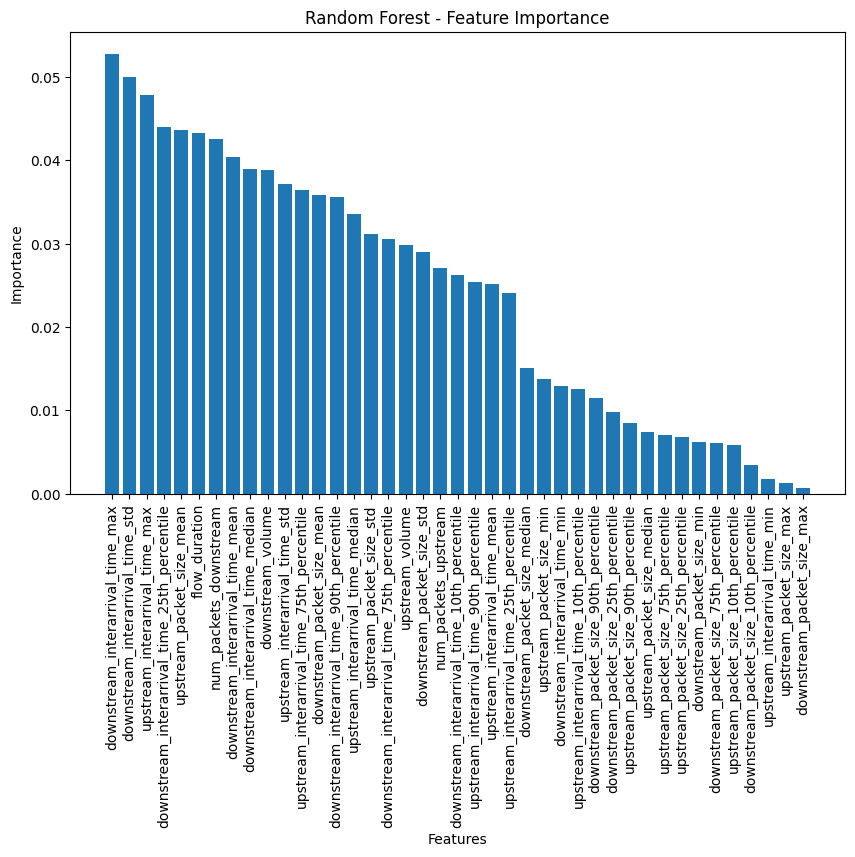

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import multiprocessing


# Read the feature data
data = pd.read_csv("features.csv")
data.dropna(inplace=True)

# Map labels to 0 and 1
data['label'] = data['label'].map({'Cellular': 0, 'Wired': 1})

# Split the data into features and labels
X = data.drop('label', axis=1)
y = data['label'].values

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the reduced parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV for Random Forest with all available CPU cores
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=multiprocessing.cpu_count())

# Perform grid search for Random Forest
grid_search_rf.fit(X_train, y_train)

# Get the best parameters and best score for Random Forest
best_params_rf = grid_search_rf.best_params_
best_score_rf = grid_search_rf.best_score_

print("Best Parameters for Random Forest:", best_params_rf)
print("Best Score for Random Forest:", best_score_rf)

# Evaluate the Random Forest model with best parameters on test set
best_rf_classifier = grid_search_rf.best_estimator_
y_pred_rf = best_rf_classifier.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, best_rf_classifier.predict_proba(X_test)[:, 1])
print("Test Set Accuracy for Random Forest:", accuracy_rf)
print("F1 Score for Random Forest:", f1_rf)
print("ROC AUC Score for Random Forest:", roc_auc_rf)

# Initialize Logistic Regression classifier
logistic_classifier = LogisticRegression(random_state=42)

# Train the Logistic Regression classifier
logistic_classifier.fit(X_train, y_train)

# Predict labels for the test set using Logistic Regression
y_pred_logistic = logistic_classifier.predict(X_test)

# Evaluate the Logistic Regression model on test set
accuracy_logistic = accuracy_score(y_test, y_pred_logistic)
f1_logistic = f1_score(y_test, y_pred_logistic)
roc_auc_logistic = roc_auc_score(y_test, logistic_classifier.predict_proba(X_test)[:, 1])
print("\nTest Set Accuracy for Logistic Regression:", accuracy_logistic)
print("F1 Score for Logistic Regression:", f1_logistic)
print("ROC AUC Score for Logistic Regression:", roc_auc_logistic)

# Baseline: Random Prediction
dummy_classifier = DummyClassifier(strategy='uniform', random_state=42)
dummy_classifier.fit(X_train, y_train)
y_pred_dummy = dummy_classifier.predict(X_test)

# Evaluate the baseline model on test set
accuracy_random = accuracy_score(y_test, y_pred_dummy)
f1_random = f1_score(y_test, y_pred_dummy)
roc_auc_random = 0.5  # For random predictions, ROC AUC is expected to be around 0.5
print("\nTest Set Accuracy for Random Prediction (Baseline):", accuracy_random)
print("F1 Score for Random Prediction (Baseline):", f1_random)
print("ROC AUC Score for Random Prediction (Baseline):", roc_auc_random)

# Plot feature importance for Random Forest
feature_importance_rf = best_rf_classifier.feature_importances_
sorted_idx_rf = feature_importance_rf.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importance_rf[sorted_idx_rf], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_idx_rf], rotation=90)
plt.title("Random Forest - Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Read the feature data
data = pd.read_csv("features.csv")
data.dropna(inplace=True)

# Map labels to 0 and 1
data['label'] = data['label'].map({'Cellular': 0, 'Wired': 1})

# Split the data into features and labels
X = data.drop('label', axis=1)
y = data['label']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature selection based on importance
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
sfm = SelectFromModel(rf_classifier, threshold=0.01)
sfm.fit(X_train, y_train)
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

# Evaluate the model on the test set
# Evaluate the model on the test set
loss, accuracy_nn = model.evaluate(X_test_scaled, y_test, verbose=0)
y_pred_prob_nn = model.predict(X_test_scaled).flatten()
y_pred_nn = (y_pred_prob_nn > 0.5).astype(int)
f1_nn = f1_score(y_test, y_pred_nn)
roc_auc_nn = roc_auc_score(y_test, y_pred_prob_nn)

print("Test Set Accuracy for Neural Network:", accuracy_nn)
print("F1 Score for Neural Network:", f1_nn)
print("ROC AUC Score for Neural Network:", roc_auc_nn)

print("Test Set Accuracy for Neural Network:", accuracy_nn)
print("F1 Score for Neural Network:", f1_nn)
print("ROC AUC Score for Neural Network:", roc_auc_nn)


Epoch 1/100
124/124 [==============================] - 1s 3ms/step - loss: 0.5743 - accuracy: 0.7030 - val_loss: 0.5336 - val_accuracy: 0.7341
Epoch 2/100
124/124 [==============================] - 0s 2ms/step - loss: 0.5088 - accuracy: 0.7606 - val_loss: 0.5133 - val_accuracy: 0.7477
Epoch 3/100
124/124 [==============================] - 0s 2ms/step - loss: 0.4855 - accuracy: 0.7735 - val_loss: 0.5056 - val_accuracy: 0.7705
Epoch 4/100
124/124 [==============================] - 0s 2ms/step - loss: 0.4746 - accuracy: 0.7803 - val_loss: 0.5026 - val_accuracy: 0.7795
Epoch 5/100
124/124 [==============================] - 0s 2ms/step - loss: 0.4660 - accuracy: 0.7846 - val_loss: 0.5054 - val_accuracy: 0.7591
Epoch 6/100
124/124 [==============================] - 0s 2ms/step - loss: 0.4583 - accuracy: 0.7828 - val_loss: 0.4922 - val_accuracy: 0.7614
Epoch 7/100
124/124 [==============================] - 0s 2ms/step - loss: 0.4510 - accuracy: 0.7904 - val_loss: 0.4893 - val_accuracy: 0.7591